In [50]:
import xgboost as xgb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import weather_and_time_functions as weather_time

In [35]:
pd.set_option('display.max_columns',None)
scaler = StandardScaler()

flight_df = pd.read_feather('data/v2_clean_flight')
flight_test_df = pd.read_feather('data/v1_clean_flight_test')
fuel_consumption_df = pd.read_feather('data/v1_clean_fuel_consumption')
passenger_df = pd.read_feather('data/v1_clean_passenger')

In [36]:
# def duration_to_rank(x):
#     if x == 'short':
#         return 0
#     elif x =='medium':
#         return 1
#     else:
#         return 2

# flight_df['flight_duration'] = flight_df['flight_duration'].apply(lambda x: duration_to_rank(x))
## Not significant to the final model of features. 

In [37]:
dep_hour = weather_time.obtain_depart_hour(flight_df)
arr_hour = weather_time.obtain_arrival_hour(flight_df)
flight_df['dep_hour'] = dep_hour
flight_df['arr_hour'] = arr_hour
flight_df.drop('hour',axis=1,inplace=True)

In [38]:
flight_df['day'] = pd.to_datetime(flight_df['fl_date'],yearfirst=True).dt.day
flight_df['month'] = flight_df['month'].astype(int)
flight_df['dep_hour'] = flight_df['dep_hour'].astype(int)
flight_df['arr_hour'] = flight_df['arr_hour'].astype(int)

In [39]:
num_cols = ['crs_elapsed_time','distance','month','arr_hour']
cat_cols = ['origin','dest','op_unique_carrier']
y_target = flight_df['arr_delay'].fillna(0)

In [40]:
flight_model = flight_df[['crs_elapsed_time','distance','month','arr_hour','origin','dest','op_unique_carrier']]
flight_model = pd.get_dummies(flight_model, columns=cat_cols)
flight_model

,crs_elapsed_time,distance,month,arr_hour,origin_ABE,origin_ABI,origin_ABQ,origin_ABR,origin_ABY,origin_ACK,origin_ACT,origin_ACV,origin_ACY,origin_ADQ,origin_AEX,origin_AGS,origin_AKN,origin_ALB,origin_ALO,origin_ALW,origin_AMA,origin_ANC,origin_APN,origin_ART,origin_ASE,origin_ATL,origin_ATW,origin_ATY,origin_AUS,origin_AVL,origin_AVP,origin_AZA,origin_AZO,origin_BDL,origin_BET,origin_BFF,origin_BFL,origin_BFM,origin_BGM,origin_BGR,origin_BHM,origin_BIL,origin_BIS,origin_BJI,origin_BKG,origin_BLI,origin_BLV,origin_BMI,origin_BNA,origin_BOI,origin_BOS,origin_BPT,origin_BQK,origin_BQN,origin_BRD,origin_BRO,origin_BRW,origin_BTM,origin_BTR,origin_BTV,origin_BUF,origin_BUR,origin_BWI,origin_BZN,origin_CAE,origin_CAK,origin_CDC,origin_CDV,origin_CGI,origin_CHA,origin_CHO,origin_CHS,origin_CID,origin_CIU,origin_CKB,origin_CLE,origin_CLL,origin_CLT,origin_CMH,origin_CMI,origin_CMX,origin_CNY,origin_COD,origin_COS,origin_COU,origin_CPR,origin_CRP,origin_CRW,origin_CSG,origin_CVG,origin_CWA,origin_CYS,origin_DAB,origin_DAL,origin_DAY,origin_DBQ,origin_DCA,origin_DEN,origin_DFW,origin_DHN,origin_DIK,origin_DLG,origin_DLH,origin_DRO,origin_DRT,origin_DSM,origin_DTW,origin_DUT,origin_DVL,origin_EAR,origin_EAT,origin_EAU,origin_ECP,origin_EGE,origin_EKO,origin_ELM,origin_ELP,origin_ERI,origin_ESC,origin_EUG,origin_EVV,origin_EWN,origin_EWR,origin_EYW,origin_FAI,origin_FAR,origin_FAT,origin_FAY,origin_FCA,origin_FLG,origin_FLL,origin_FLO,origin_FNT,origin_FSD,origin_FSM,origin_FWA,origin_GCC,origin_GCK,origin_GEG,origin_GFK,origin_GGG,origin_GJT,origin_GNV,origin_GPT,origin_GRB,origin_GRI,origin_GRK,origin_GRR,origin_GSO,origin_GSP,origin_GTF,origin_GTR,origin_GUC,origin_GUM,origin_HDN,origin_HGR,origin_HHH,origin_HIB,origin_HLN,origin_HNL,origin_HOB,origin_HOU,origin_HPN,origin_HRL,origin_HSV,origin_HTS,origin_HVN,origin_HYA,origin_HYS,origin_IAD,origin_IAG,origin_IAH,origin_ICT,origin_IDA,origin_ILM,origin_IMT,origin_IND,origin_INL,origin_IPT,origin_ISN,origin_ISP,origin_ITH,origin_ITO,origin_JAC,origin_JAN,origin_JAX,origin_JFK,origin_JHM,origin_JLN,origin_JMS,origin_JNU,origin_KOA,origin_KTN,origin_LAN,origin_LAR,origin_LAS,origin_LAW,origin_LAX,origin_LBB,origin_LBE,origin_LBF,origin_LBL,origin_LCH,origin_LCK,origin_LEX,origin_LFT,origin_LGA,origin_LGB,origin_LIH,origin_LIT,origin_LNK,origin_LNY,origin_LRD,origin_LSE,origin_LWB,origin_LWS,origin_LYH,origin_MAF,origin_MBS,origin_MCI,origin_MCO,origin_MDT,origin_MDW,origin_MEI,origin_MEM,origin_MFE,origin_MFR,origin_MGM,origin_MHK,origin_MHT,origin_MIA,origin_MKE,origin_MKG,origin_MKK,origin_MLB,origin_MLI,origin_MLU,origin_MMH,origin_MOB,origin_MOT,origin_MQT,origin_MRY,origin_MSN,origin_MSO,origin_MSP,origin_MSY,origin_MTJ,origin_MVY,origin_MYR,origin_OAJ,origin_OAK,origin_OGD,origin_OGG,origin_OGS,origin_OKC,origin_OMA,origin_OME,origin_ONT,origin_ORD,origin_ORF,origin_ORH,origin_OTH,origin_OTZ,origin_OWB,origin_PAE,origin_PAH,origin_PBG,origin_PBI,origin_PDX,origin_PGD,origin_PGV,origin_PHF,origin_PHL,origin_PHX,origin_PIA,origin_PIB,origin_PIE,origin_PIH,origin_PIR,origin_PIT,origin_PLN,origin_PNS,origin_PPG,origin_PQI,origin_PRC,origin_PSC,origin_PSE,origin_PSG,origin_PSM,origin_PSP,origin_PUB,origin_PUW,origin_PVD,origin_PVU,origin_PWM,origin_RAP,origin_RDD,origin_RDM,origin_RDU,origin_RFD,origin_RHI,origin_RIC,origin_RKS,origin_RNO,origin_ROA,origin_ROC,origin_ROW,origin_RST,origin_RSW,origin_SAF,origin_SAN,origin_SAT,origin_SAV,origin_SBA,origin_SBN,origin_SBP,origin_SBY,origin_SCC,origin_SCE,origin_SCK,origin_SDF,origin_SEA,origin_SFB,origin_SFO,origin_SGF,origin_SGU,origin_SHD,origin_SHV,origin_SIT,origin_SJC,origin_SJT,origin_SJU,origin_SLC,origin_SLN,origin_SMF,origin_SMX,origin_SNA,origin_SPI,origin_SPN,origin_SPS,origin_SRQ,origin_STC,origin_STL,origin_STS,origin_STT,origin_STX,origin_SUN,origin_SUX,origin_SWF,origin_SWO,origin_SYR,origin_TLH,origin_TOL,origin_TPA,origin_TRI,origin_TTN,origin_TUL,origin_TUS,origin_TVC,origin_TWF,origin_TXK,origin_TYR,origin_TYS,origin_UI

In [41]:
x_train,x_test,y_train,y_test = train_test_split(flight_model,y_target,test_size=0.3)

In [42]:
#Best parameter is learning_rate 0.1, max_depth 3, n_estimators 50. Took 65minutes to run!, gives r2 of 0.0074

# params = {
#     'max_depth': [3,4,5,6,7],
#     'learning_rate': [0.001,0.01,0.1],
#     'n_estimators': [50,70,100,200]
# }
# xgboost = xgb.XGBRegressor()
# regCV = GridSearchCV(estimator=xgboost,cv=5,param_grid=params)
# regCV.fit(x_train,y_train)
# regCV.best_params_ 

In [47]:
xgboost = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=0.1, max_depth=3, n_estimators=50)
xgboost.fit(x_train,y_train)
y_pred = xgboost.predict(x_test)

0.013850244047477811

In [48]:
print("R2 Score: ", r2_score(y_test,y_pred))
print("Mean Squared Error: ", mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: ", mean_squared_error(y_test,y_pred, squared=False))

R2 Score:  0.013850244047477811
Mean Squared Error:  2332.2203331164724
Root Mean Squared Error:  48.293067133041696


In [44]:
#highest is ~0.013 with 'crs_elapsed_time','distance','month','arr_hour','origin','dest','op_unique_carrier'

<AxesSubplot: title={'center': 'XGBoost Model on Flight Arrival Delays'}, xlabel='Actual results', ylabel='Predicted results'>

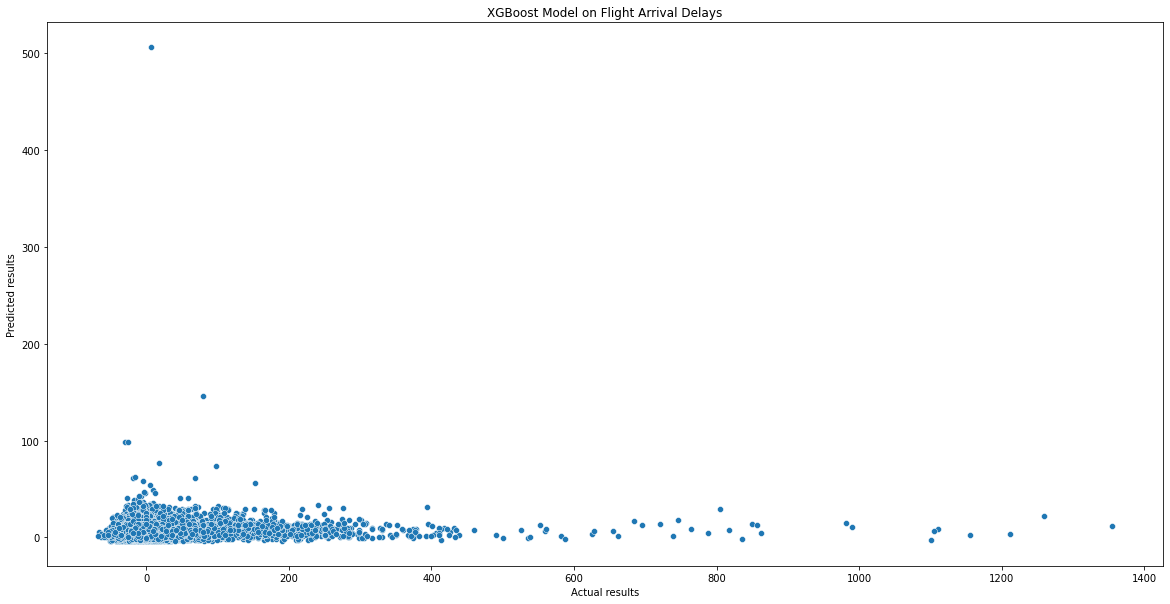

In [95]:
plt.figure(figsize=(20,10))
plt.xlabel('Actual results')
plt.ylabel('Predicted results')
plt.title('XGBoost Model on Flight Arrival Delays')
sns.scatterplot(x=y_test,y=y_pred)
